# Detecting Troll/Bot/Brigading Activity on Streaming Chat Data

### Data Prep

In [1]:
import time
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

# The files were split into many different Pickle files; we needed to load them via Pandas. In a perfect world,
# uploading via HDFS would be quicker (if Spark supported Pickle files), but we only have a single worker node.

full_data = pd.read_pickle('gs://dataproc-staging-us-east1-935674292254-8vstrevf/Twitch_data/ICWSM19_data/*.pkl')

# Data source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VE0IVQ

In [6]:
full_data.info()
'''
Description of columns follows below:
body: Actual text for user chat
channel_id: Channel identifier (integer)
commenter_id: User identifier (integer)
commenter_type: User type ['user', 'staff', 'global_mod'] (character)
created_at: Time of when chat was entered (ISO 8601 date and time)
fragments: Chat text including parsing information of Twitch emote (JSON list)
offset: Time offset between start time of video stream and the time of when chat was entered (float)
updated_at: Time of when chat was edited (ISO 8601 date and time)
video_id: Video identifier (integer)

'''

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2722109 entries, 0 to 3994358
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   body            object 
 1   channel_id      object 
 2   commenter_id    object 
 3   commenter_type  object 
 4   created_at      object 
 5   fragments       object 
 6   offset          float64
 7   updated_at      object 
 8   video_id        object 
dtypes: float64(1), object(8)
memory usage: 207.7+ MB


"\nDescription of columns follows below:\nbody: Actual text for user chat\nchannel_id: Channel identifier (integer)\ncommenter_id: User identifier (integer)\ncommenter_type: User type ['user', 'staff', 'global_mod'] (character)\ncreated_at: Time of when chat was entered (ISO 8601 date and time)\nfragments: Chat text including parsing information of Twitch emote (JSON list)\noffset: Time offset between start time of video stream and the time of when chat was entered (float)\nupdated_at: Time of when chat was edited (ISO 8601 date and time)\nvideo_id: Video identifier (integer)\n\n"

In [2]:
# Drop unnecessary features.

full_data = full_data.drop(columns=['commenter_type', 'fragments', 'offset', 'updated_at'])

In [3]:
# Convert 'created_at' to datetime objects.

full_data.created_at = pd.to_datetime(full_data.created_at)
full_data.head(10)

,body,channel_id,commenter_id,created_at,video_id
0,STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER...,40972890,110969182,2018-06-24 17:07:43.067000+00:00,277073045
1,NOT LIVE rooREE rooREE rooREE,40972890,109856709,2018-06-24 17:07:43.168000+00:00,277073045
2,rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooB...,40972890,56159955,2018-06-24 17:07:44.631000+00:00,277073045
3,See,40972890,78678476,2018-06-24 17:07:45.602000+00:00,277073045
4,rooPog,40972890,30898708,2018-06-24 17:07:45.802000+00:00,277073045
5,rooPog,40972890,45938332,2018-06-24 17:07:45.981000+00:00,277073045
6,rooPog,40972890,27713718,2018-06-24 17:07:46.177000+00:00,277073045
7,rooHappy rooHappy rooHappy rooHappy rooHappy,40972890,30008739,2018-06-24 17:07:46.327000+00:00,277073045
8,rooREE LATE rooREE LATE rooREE LATE rooREE LAT...,40972890,98102384,2018-06-24 17:07:47.358000+00:00,277073045
9,rooREE rooREE rooREE,40972890,106988399,2018-06-24 17:07:47.783000+00:00,277073045


In [4]:
# Find the starting and endpoint point for the dataset. This is needed to create bins or windows to
# mimick streaming data.

start, end = full_data.created_at.min(), full_data.created_at.max()
start, end

(Timestamp('2018-03-06 18:20:53.272000+0000', tz='UTC'),
 Timestamp('2018-06-25 01:04:55.024000+0000', tz='UTC'))

In [5]:
# Create bins to bucket each message within X seconds into its own DF/file.

dt_increments = pd.date_range(freq='1000S', start=start, end=end)
labels = [i for i in range(1, len(dt_increments))]

print(f'{len(dt_increments)} bins with this frequency.')

9529 bins with this frequency.


In [6]:
# Create a new column to indicate bin.

full_data['bin'] = pd.cut(full_data.created_at,
                   bins=dt_increments,
                   labels=labels)

In [7]:
full_data = full_data.sort_values(by=['bin'])
full_data.head(5)

,body,channel_id,commenter_id,created_at,video_id,bin
3572218,try again,40972890,176775772,2018-03-06 18:35:42.807000+00:00,247607785,1
3572008,7463,40972890,31628501,2018-03-06 18:32:38.394000+00:00,247607785,1
3572007,7463,40972890,61747377,2018-03-06 18:32:37.502000+00:00,247607785,1
3572006,GreyFox474 roo7,40972890,45823077,2018-03-06 18:32:36.634000+00:00,247607785,1
3572005,rooWhat,40972890,19264788,2018-03-06 18:32:35.804000+00:00,247607785,1


In [8]:
full_data = full_data.sort_values(by=['bin'], ascending=False)
full_data.head(5)

,body,channel_id,commenter_id,created_at,video_id,bin
31193,Clap2 rooPog,40972890,67157187,2018-06-25 00:55:02.097000+00:00,277073045,9528
31690,"cmon its 3 in the m,orning here...",40972890,205163144,2018-06-25 01:00:50.083000+00:00,277073045,9528
31699,rooLove rooLove rooLove rooLove rooLove rooLov...,40972890,34728298,2018-06-25 01:00:51.705000+00:00,277073045,9528
31698,FireDuck,40972890,50755248,2018-06-25 01:00:51.422000+00:00,277073045,9528
31697,rooLove rooLove rooLove rooLove rooLove rooLov...,40972890,39186645,2018-06-25 01:00:51.277000+00:00,277073045,9528


In [9]:
# Create a CSV file for each bin and write to Cloud Storage (Spark will read from this for streaming later on).
# Commenting out as these files already exist - no need to run again.

# for _bin in labels:
#     file_name = str(_bin).rjust(6, '0')
#     full_data.loc[full_data['bin'] == _bin].to_csv(f'gs://dataproc-staging-us-east1-935674292254-8vstrevf/Twitch_data/CSV_data/{file_name}.csv')
            

### Processing
#### Two Approaches: Python and Spark (PySpark)

Ultimately, while we used both and have working examples, due to the volume of data being streamed and small cluster (we deployed a single name/worker node cluster) created in Dataproc, jobs failed.

### Python

#### Bloom Filter

In [10]:
# Load a list of 'restricted' words that we want to check for in chat messages. If one of these
# words are present in a message, we will block it entirely.

hateFile = pd.read_csv('gs://dataproc-staging-us-east1-935674292254-8vstrevf/Hate_Words.csv')
hateWords = list(hateFile['word'])

In [11]:
import numpy as np
from functools import partial

class UHF:
    """A factory for producing a universal family of hash functions"""

    @staticmethod
    def isPrime(k):
        if k%2==0:
            return False
        for i in range(3, int(np.sqrt(k)), 2):
            if k%i == 0:
                return False
        return True

    def __init__(self, n):
        """Universe size is n"""
        self.n = n
        m = 0
        if n%2==0:
            m = n+1
        else:
            m = n+2
        while not(UHF.isPrime(m)):
            m = m+2
        self.p = m

    def makeHash(self, m):
        """Returns a random hash function

        m: table size
        """
        a = np.random.randint(1,self.p-1)
        b = np.random.randint(0,self.p-1)
        return lambda k: ((a*k+b)%self.p)%m



def fnv_hash(s):
    """Returns 32-bit number as slot index

    Uses the FNV algorithm from http://isthe.com/chongo/tech/comp/fnv/

    Args:
        s (str): key to be hashed
    """
    hashval = 0x811c9dc50
    for ch in s:
        hashval *= 0x01000193
        hashval ^= ord(ch)
        hashval &= 0xffffffff
    return hashval


class String_UHF:
    """Universal Hash family for strings

    We will use the Mersenne prime 2**31 - 1 = 2147483647
    in the hash family: while we have not done so here,
    division modulo Mersenne primes can be computed very fast."""

    def __init__(self, p=31):
        self.p = 2**p -1
        self.a = np.random.randint(1, self.p -1)
        self.b = np.random.randint(0, self.p -1)

    def makeHash(self, m):
        """Returns hash function from str -> [0, m)

        Args:
            m (int): table size
        """
        def __rollingHash(x, s):
            """Implements a rolling hash

            Treat the string's ord() values as coefficients
            of a polynomial in x, and evaluate modulo self.p

            Args:
                x (int)
                s (str): string to be hashed
            """
            hashval = 0x811c9dc50
            for ch in s:
                hashval = ((hashval * x) + ord(ch)) % self.p
            return ((self.a * hashval + self.b) % self.p) % m

        k = np.random.randint(1, self.p -1)
        return partial(__rollingHash, k)

class BloomFilter:
    ''' Class creates our bloom filter and accepts the words that we're
    looking for. Code uses the String_UHF from the professor so not currently
    sure how we can read that in yet. Initializes to the optimal bits and hashes.
    
    Args:
        word_list: list of words to be filtered
    '''
    def __init__(self, word_list):
        self.words = word_list
        self.len = len(self.words)
        self.fn_rate = 0.01
        self.bits = int(-self.len*np.log(self.fn_rate) / (np.log(2)**2))
        self.optHash = int(self.bits/self.len * np.log(2))
        self.bloom = np.zeros(self.bits)
        self.hash_fn = String_UHF()
        self.hashes = [self.hash_fn.makeHash(self.bits) for i in range (self.optHash)]
        for elem in self.words:
            for h in self.hashes:
                self.bloom[h(elem)] = 1

    def check_membership(self,elem):
        '''Returns True if all bits corresponding to the element are set
        - by Professor
        '''
        return all([self.bloom[h(elem)] == 1 for h in self.hashes])

In [12]:
# Bloom filter implementation

TwitchBloom = BloomFilter(hateWords)

In [13]:
# Testing the filter.

msg = 'kill'
print(TwitchBloom.check_membership(msg))

True


#### LSH

In [14]:
from datasketch import MinHash, MinHashLSH
from nltk.util import ngrams

In [15]:
# Load a test dataframe for testing the LSH implementation.

test = full_data.head(1000)

In [16]:
# Basic/simple tokenization

test['msg'] = test['body'].str.split()

/tmp/ipykernel_3155/185678468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['msg'] = test['body'].str.split()


In [24]:
# Testing the Bloom filter and LSH (with 95% similarity as the threshold) together:
# 1) Check message against Bloom filter, if not caught:
# 2) Insert into minhash table/apply LSH check

# First, step 1:

lsh = MinHashLSH(threshold=0.95, num_perm=128)

minhashes = dict()

for msg in test.iterrows():
    m1 = MinHash(num_perm=128)

    for word in msg[1]['msg']:
        # Check Bloom filter before proceeding with LSH
        if TwitchBloom.check_membership(word) == True:
            print('Blocked word detected in message: ',msg[1]['body'])
            break
        else:
            m1.update(word.encode('utf8'))
    lsh.insert(msg[0], m1)
    minhashes[msg[0]] = m1    


Blocked word detected in message:  NotAerial technically no the game itself is pretty good but the dlc gives it much more stuff so its a good thing to have
Blocked word detected in message:  my pc died, did we kill the thing?
Blocked word detected in message:  rooSellout Do you have Amazon Prime and want to subscribe? https://twitch.amazon.com/prime and go to https://www.twitch.tv/admiralbahroo/subscribe to subscribe for free rooSellout
Blocked word detected in message:  So much stress.
Blocked word detected in message:  @KradoxArcticFox Do i need to buy any DLC?
Blocked word detected in message:  you still haven't fucked with the warrens
Blocked word detected in message:  because there is as much rng in this game as rolling a 1d100 dice
Blocked word detected in message:  holy crap 10k
Blocked word detected in message:  probably leave buildings alone imo, i wouldve stopped at the bank
Blocked word detected in message:  Do the girls have special lines for visiting the brothel?
Blocked w

In [25]:
# Now step 2:

ctr = 0

for i in (minhashes.keys()):
    result = lsh.query(minhashes[i])
    result.remove(i)
    
    # Two different thresholds; for a single word, a higher threshold
    if len(test.loc[i]['body']) == 1:
        if len(result) > 10:
            ctr += 1
            print('BLOCKED!')
            print('ID: ', i)
            print('Message: ', test.loc[i]['body'])
            print('Reason: ', 'blocked for having a 95%+ similar message in this window/bin.')
            print('\n')
            print(f'{ctr} messages blocked so far in this window/bin.')
    elif len(test.loc[i]['body']) > 1:
        if len(result) > 0:
            ctr += 1
            print('BLOCKED!')
            print('ID: ', i)
            print('Message: ', test.loc[i]['body'])
            print('Reason: ', 'blocked for having a 95%+ similar message in this window/bin.')
            print('\n')
            print(f'{ctr} messages blocked so far in this window/bin.')

            
print(f'Reduction of chat activity by {round((ctr/len(test))*100, 3)}%')

BLOCKED!
ID:  31193
Message:  Clap2 rooPog
Reason:  blocked for having a 95%+ similar message in this window/bin.


1 messages blocked so far in this window/bin.
BLOCKED!
ID:  31699
Message:  rooLove rooLove rooLove rooLove rooLove rooLove rooLove rooLove
Reason:  blocked for having a 95%+ similar message in this window/bin.


2 messages blocked so far in this window/bin.
BLOCKED!
ID:  31697
Message:  rooLove rooLove rooLove rooLove rooLove rooLove rooLove rooLove rooLove rooLove rooLove
Reason:  blocked for having a 95%+ similar message in this window/bin.


3 messages blocked so far in this window/bin.
BLOCKED!
ID:  31696
Message:  rooLove rooLove rooLove rooLove rooLove
Reason:  blocked for having a 95%+ similar message in this window/bin.


4 messages blocked so far in this window/bin.
BLOCKED!
ID:  31695
Message:  rooLove rooLove rooLove
Reason:  blocked for having a 95%+ similar message in this window/bin.


5 messages blocked so far in this window/bin.
BLOCKED!
ID:  31694
Messag

#### Implementation: Bloom Filter & LSH Together on Simulated Streaming Data

In [51]:
# Now let's implement this on streaming data, by 'bins' defined above. Showing the first
# 10 bins as an example.

results = {
"volume" : [],
"rate" : []}

for _bin in labels[:10]:
    window = full_data.loc[full_data['bin'] == _bin]
    window['msg'] = window['body'].str.split()
    
    
    lsh = MinHashLSH(threshold=0.95, num_perm=128)
    minhashes = dict()

    ctr_bloom = 0
    
    for msg in window.iterrows():

        m1 = MinHash(num_perm=128)

        for word in msg[1]['msg']:
            # Check Bloom filter before proceeding with LSH
            if TwitchBloom.check_membership(word) == True:
                ctr_bloom += 1
                break
            else:
                m1.update(word.encode('utf8'))
        lsh.insert(msg[0], m1)
        minhashes[msg[0]] = m1
    
    ctr_lsh = 0

    for i in (minhashes.keys()):
        result = lsh.query(minhashes[i])
        result.remove(i)

        # Two different thresholds; for a single word, a higher threshold
        if len(window.loc[i]['body']) == 1:
            if len(result) > 10:
                ctr_lsh += 1
        elif len(window.loc[i]['body']) > 1:
            if len(result) > 0:
                ctr_lsh += 1

    print(f'Reduction of chat activity by {round(((ctr_lsh+ctr_bloom)/len(window))*100,3)}% for bin/window {labels.index(_bin)} ({ctr_lsh+ctr_bloom} out of {len(window)} messages)')
    print(f'Bloom filter reduction: {ctr_bloom}')
    print(f'LSH reduction: {ctr_lsh}\n')
    results['volume'].append(len(window))
    results['rate'].append(round(((ctr_lsh+ctr_bloom)/len(window))*100,3))

/tmp/ipykernel_2615/900842355.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window['msg'] = window['body'].str.split()


Reduction of chat activity by 47.939% for bin/window 0 (791 out of 1650 messages)
Bloom filter reduction: 64
LSH reduction: 727

Reduction of chat activity by 44.162% for bin/window 1 (870 out of 1970 messages)
Bloom filter reduction: 73
LSH reduction: 797

Reduction of chat activity by 48.854% for bin/window 2 (1321 out of 2704 messages)
Bloom filter reduction: 129
LSH reduction: 1192

Reduction of chat activity by 49.92% for bin/window 3 (1251 out of 2506 messages)
Bloom filter reduction: 159
LSH reduction: 1092

Reduction of chat activity by 61.512% for bin/window 4 (1953 out of 3175 messages)
Bloom filter reduction: 215
LSH reduction: 1738

Reduction of chat activity by 48.956% for bin/window 5 (1055 out of 2155 messages)
Bloom filter reduction: 113
LSH reduction: 942

Reduction of chat activity by 44.968% for bin/window 6 (706 out of 1570 messages)
Bloom filter reduction: 90
LSH reduction: 616

Reduction of chat activity by 40.882% for bin/window 7 (547 out of 1338 messages)
Bloom

In [57]:
resultsDF = pd.DataFrame(results)

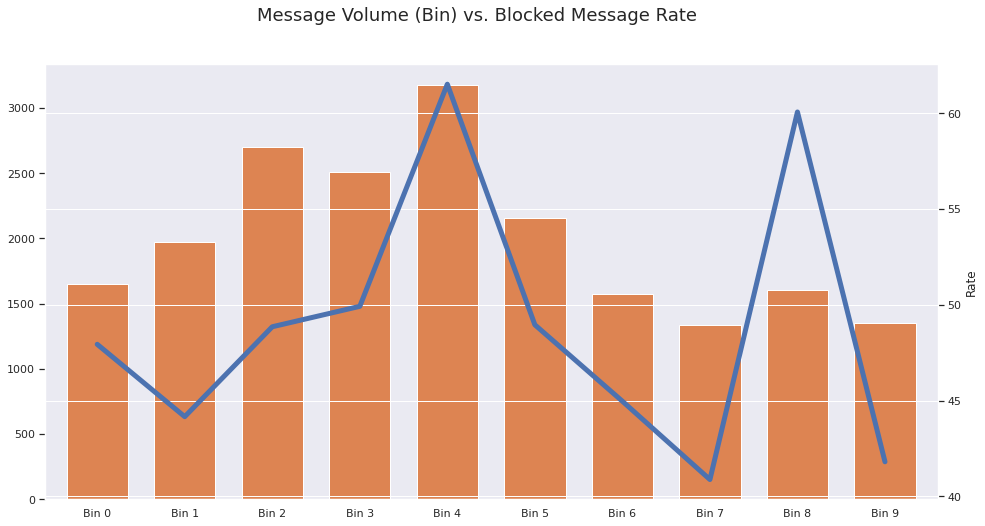

In [149]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(16,8))

width = .7

m1_t = resultsDF

m1_t['volume'].plot(kind='bar', width = width, color='C1')
m1_t['rate'].plot(secondary_y=True, linewidth = 5)

ax = plt.gca()
ax.set_xticklabels(('Bin 0', 'Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9'))
fig.suptitle('Message Volume (Bin) vs. Blocked Message Rate', fontsize=18)

plt.xlabel('Volume')
plt.ylabel('Rate')
plt.show()

#### Time Complexity Comparison: Bloom Filter vs. Traditionally Checking Membership

In [156]:
# Now let's compare how long it takes to check membership using a Bloom filer vs. 'is in' syntax.

benchmark_df = full_data.head(10000)
benchmark_df['msg'] = benchmark_df['body'].str.split()

results = {
"Size (n)" : [],
"LSH Time (s)" : [],
"Manual Time (s)" : []}

range_ = range(1,10,2)

for i in range_:
    hateWords_benchmark = hateWords*i
    Bloom_bench = BloomFilter(hateWords_benchmark)
    start_time = time.time()
    for msg in benchmark_df.iterrows():
        for word in msg[1]['msg']:
            Bloom_bench.check_membership(word)
    stop_time = time.time()
    results["Size (n)"].append(len(hateWords_benchmark))
    results["LSH Time (s)"].append(stop_time-start_time)
    
    
for i in range_:
    hateWords_benchmark = hateWords*i
    start_time = time.time()
    for msg in benchmark_df.iterrows():
        for word in msg[1]['msg']:
            if word in hateWords_benchmark:
                pass
    stop_time = time.time()
    results["Manual Time (s)"].append(stop_time-start_time)

/tmp/ipykernel_2615/1833061481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['msg'] = benchmark_df['body'].str.split()


In [157]:
results

{'Size (n)': [723, 2169, 3615, 5061, 6507],
 'LSH Time (s)': [1.418097734451294,
  1.3914134502410889,
  1.3992421627044678,
  1.4005613327026367,
  1.4040391445159912],
 'Manual Time (s)': [1.1014132499694824,
  1.869292974472046,
  2.6180291175842285,
  3.360520124435425,
  4.12244439125061]}

Text(0.5, 0, 'Size of List (n)')

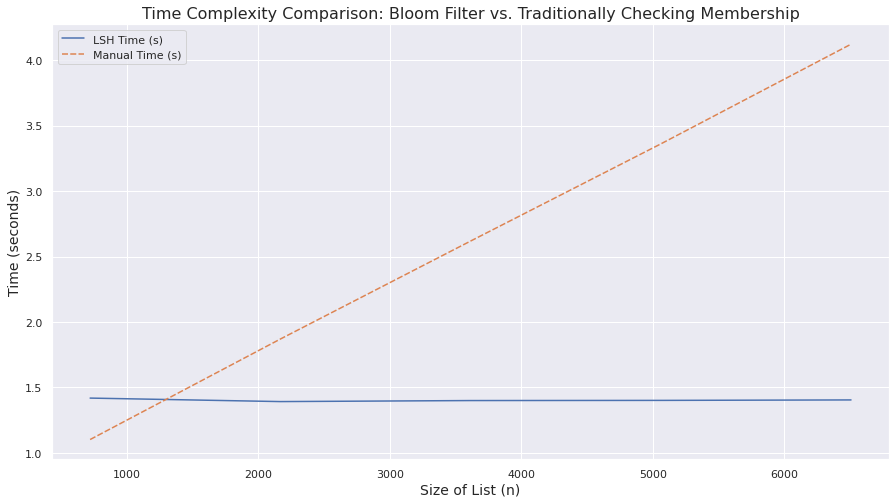

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

resultsDF = pd.DataFrame(results).set_index('Size (n)')
p = sns.lineplot(data = resultsDF)

p.set_title('Time Complexity Comparison: Bloom Filter vs. Traditionally Checking Membership', fontsize = 16)

p.set_ylabel("Time (seconds)", fontsize = 14)
p.set_xlabel("Size of List (n)", fontsize = 14)

In [ ]:
# We very clearly see O(1) complexity for the Bloom filter and O(n) for checking membership via 'is in'.

### Spark (PySpark)

#### Spark Streaming Example

In [2]:
# Create a Spark Session

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Import a single CSV to infer the schema, so this schema can be set for the entire stream.

part = spark.read.csv(
    'gs://dataproc-staging-us-east1-935674292254-8vstrevf/Twitch_data/CSV_data/000001.csv',
    header=True,
    inferSchema=True,
)

In [4]:
dataSchema = part.schema
dataSchema

StructType(List(StructField(_c0,IntegerType,true),StructField(body,StringType,true),StructField(channel_id,IntegerType,true),StructField(commenter_id,IntegerType,true),StructField(created_at,StringType,true),StructField(video_id,IntegerType,true),StructField(bin,IntegerType,true)))

In [5]:
# Start streaming data (only the first 100 CSVs are used here)

streaming = (
    spark.readStream.schema(dataSchema)
    .option('maxFilesPerTrigger', 1)
    .csv('gs://dataproc-staging-us-east1-935674292254-8vstrevf/Twitch_data/CSV_data_first100/')
)

In [9]:
# Example of streaming data based on loaded Twitch dataset. Ideally, the Spark models shown below would be
# applied to the _df object throughout the stream, but as mentioned our cluster was not powerful enough to
# do this given the volume of data.

# To stop run 'activityQuery.stop()'

dest_count = streaming.groupBy('body').count()

activityQuery = (
    dest_count.writeStream.queryName("msg_counter")
    .format("memory")
    .outputMode("complete")
    .start()
)
      
for x in range(50):
    _df = spark.sql(
        "SELECT * FROM msg_counter"
#         "SELECT * FROM msg_counter WHERE body != 'body' AND count >= 2"
    )
    if _df.count() > 0:
        _df.show(10)
    time.sleep(0.5)

21/11/30 01:52:45 WARN org.apache.spark.sql.streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-48546e32-dd2e-42f3-8899-4b35e2041d59. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
21/11/30 01:52:45 WARN org.apache.spark.sql.streaming.StreamingQueryManager: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows

+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|Is this the seque...|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|ooh buy I love th...|    1|
|I am working ON T...|    1|
|                  ye|    1|
|That was fast. Ba...|    1|
| @therealkamael roo7|    1|
+--------------------+-----+
only showing top 10 rows

+--------------------+-----+
|                body|count|
+--------------------+-----+
|        monkaSHAKE ⌚|    1|
|Is this the seque...|    1|
|     rescVV1 rescVV2|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|               haloo|    1|
|ooh buy I love th...|    1|
|              HEWWO?|    1|
+--------------------+-----+
only showing top 10 rows

+--------------------+-----+
|                body|count|
+--------------------+-----+
|        monkaSHAKE ⌚|    1|
|Is this the seque..

+--------------------+-----+
|                body|count|
+--------------------+-----+
|        monkaSHAKE ⌚|    1|
|Is this the seque...|    1|
|     rescVV1 rescVV2|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|               haloo|    1|
|ooh buy I love th...|    1|
|              HEWWO?|    1|
+--------------------+-----+
only showing top 10 rows

+--------------------+-----+
|                body|count|
+--------------------+-----+
|        monkaSHAKE ⌚|    1|
|Is this the seque...|    1|
|     rescVV1 rescVV2|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|               haloo|    1|
|ooh buy I love th...|    1|
|              HEWWO?|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|        monkaSHAKE ⌚|    1|
|Is this the seque...|    1|
|     rescVV1 rescVV2|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|               haloo|    1|
|ooh buy I love th...|    1|
|              HEWWO?|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|        monkaSHAKE ⌚|    1|
|Is this the seque...|    1|
|     rescVV1 rescVV2|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|               haloo|    1|
|ooh buy I love th...|    1|
|              HEWWO?|    1|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|                body|count|
+--------------------+-----+
|        monkaSHAKE ⌚|    1|
|Is this the seque...|    1|
|     rescVV1 rescVV2|    1|
|               !duck|    3|
|999 red balloons ...|    1|
|             PepePls|    2|
|                 666|    1|
|               haloo|    1|
|ooh buy I love th...|    1|
|              HEWWO?|    1|
+--------------------+-----+
only showing top 10 rows



In [10]:
spark.streams.active[0].isActive

True

In [11]:
activityQuery.status

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [12]:
activityQuery.stop()

21/11/30 01:53:40 ERROR org.apache.spark.sql.execution.datasources.v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@2be75e6b is aborting.
21/11/30 01:53:40 ERROR org.apache.spark.sql.execution.datasources.v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@2be75e6b aborted.
21/11/30 01:53:40 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 185.0 in stage 151.0 (TID 900) (final-project-m.c.final-project-331801.internal executor 3): TaskKilled (Stage cancelled)
21/11/30 01:53:40 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 194.0 in stage 151.0 (TID 908) (final-project-m.c.final-project-331801.internal executor 3): TaskKilled (Stage cancelled)
21/11/30 01:53:40 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 80.0 in stage 151.0 (TID 903) (final-project-m.c.final-project-331801.internal executor 2): TaskKilled (Stage cancel

#### Applying LSH via PySpark Example

In [13]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import split, col

# First, we must take the messages ('body') and vectorize them. However, before we can do this, we need
# to change the column from a string to an array.

LSH_df = part.withColumn("body", split(col("body")," "))

LSH_df.printSchema()
LSH_df.show()

root
 |-- _c0: integer (nullable = true)
 |-- body: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- channel_id: integer (nullable = true)
 |-- commenter_id: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- video_id: integer (nullable = true)
 |-- bin: integer (nullable = true)

+-------+--------------------+----------+------------+--------------------+---------+---+
|    _c0|                body|channel_id|commenter_id|          created_at| video_id|bin|
+-------+--------------------+----------+------------+--------------------+---------+---+
|3571405|[ZTD, memories, r...|  40972890|    23623176|2018-03-06 18:25:...|247607785|  1|
|3571400|  [rooOhISam, right]|  40972890|    82351926|2018-03-06 18:25:...|247607785|  1|
|3571401|       [What, rooVV]|  40972890|   166143538|2018-03-06 18:25:...|247607785|  1|
|3571384|        [Spaceshipp]|  40972890|    44241565|2018-03-06 18:25:...|247607785|  1|
|3571402|                 [?]|  409728

In [14]:
# Now that that's done we can fit a CountVectorizerModel to 'body', adding a 'features' feature/column.

cv = CountVectorizer(inputCol="body", outputCol="features", vocabSize=10000, minDF=1.0) #,stop_words='english')?

model = cv.fit(LSH_df)

LSH_df = model.transform(LSH_df)
LSH_df.show()

+-------+--------------------+----------+------------+--------------------+---------+---+--------------------+
|    _c0|                body|channel_id|commenter_id|          created_at| video_id|bin|            features|
+-------+--------------------+----------+------------+--------------------+---------+---+--------------------+
|3571405|[ZTD, memories, r...|  40972890|    23623176|2018-03-06 18:25:...|247607785|  1|(784,[18,428,626]...|
|3571400|  [rooOhISam, right]|  40972890|    82351926|2018-03-06 18:25:...|247607785|  1|(784,[123,125],[1...|
|3571401|       [What, rooVV]|  40972890|   166143538|2018-03-06 18:25:...|247607785|  1|(784,[0,60],[1.0,...|
|3571384|        [Spaceshipp]|  40972890|    44241565|2018-03-06 18:25:...|247607785|  1|   (784,[482],[1.0])|
|3571402|                 [?]|  40972890|    62335252|2018-03-06 18:25:...|247607785|  1|    (784,[77],[1.0])|
|3571403|           [rooWhat]|  40972890|    49534518|2018-03-06 18:25:...|247607785|  1|    (784,[42],[1.0])|
|

In [15]:
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

In [16]:
# Now we can apply LSH to 'features'.

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=1000)
model = mh.fit(LSH_df)

In [17]:
LSH_df.groupBy('bin').count().show()

# This dataframe has only 512 entries, however even processing this results in failed jobs due to the
# cluster capacity, so this is being trimmed to 10 entries for display purposes (also dropping unneeded
# columns).

test_sample = model.transform(LSH_df).drop('channel_id','commenter_id','created_at','video_id').head(10)
test_sample = spark.createDataFrame(test_sample)
test_sample.show()

+---+-----+
|bin|count|
+---+-----+
|  1|  512|
+---+-----+



+-------+--------------------+---+--------------------+--------------------+
|    _c0|                body|bin|            features|              hashes|
+-------+--------------------+---+--------------------+--------------------+
|3571405|[ZTD, memories, r...|  1|(784,[18,428,626]...|[[1.27381141E8], ...|
|3571400|  [rooOhISam, right]|  1|(784,[123,125],[1...|[[1.597085847E9],...|
|3571401|       [What, rooVV]|  1|(784,[0,60],[1.0,...|[[2.2273316E7], [...|
|3571384|        [Spaceshipp]|  1|   (784,[482],[1.0])|[[8.7422106E7], [...|
|3571402|                 [?]|  1|    (784,[77],[1.0])|[[1.40615224E9], ...|
|3571403|           [rooWhat]|  1|    (784,[42],[1.0])|[[7.14951242E8], ...|
|3571404|[5, endings, POGG...|  1|(784,[139,538,708...|[[1.058336349E9],...|
|3571411|["I, think, if, y...|  1|(784,[3,15,22,107...|[[5.3370783E7], [...|
|3571406|      [Stor, rooREE]|  1|(784,[1,734],[1.0...|[[2.54642886E8], ...|
|3571407|           [rooWhat]|  1|    (784,[42],[1.0])|[[7.14951242E8], ...|

In [19]:
print("Twitch messages in the sample with a Jaccard distance smaller than 0.8:")
model.approxSimilarityJoin(test_sample, test_sample, 0.8, distCol="JaccardDistance").show()

# Note there are naturally instances of the same message matching itself. What is beneficial here
# is identifying different messages (e.g. the 3rd from last row, where _c0 is different between the
# two messages).

Twitch messages in the sample with a Jaccard distance smaller than 0.8:


+--------------------+--------------------+---------------+
|            datasetA|            datasetB|JaccardDistance|
+--------------------+--------------------+---------------+
|{3571406, [Stor, ...|{3571406, [Stor, ...|            0.0|
|{3571405, [ZTD, m...|{3571405, [ZTD, m...|            0.0|
|{3571404, [5, end...|{3571404, [5, end...|            0.0|
|{3571400, [rooOhI...|{3571400, [rooOhI...|            0.0|
|{3571401, [What, ...|{3571401, [What, ...|            0.0|
|{3571407, [rooWha...|{3571407, [rooWha...|            0.0|
|{3571403, [rooWha...|{3571407, [rooWha...|            0.0|
|{3571403, [rooWha...|{3571403, [rooWha...|            0.0|
|{3571384, [Spaces...|{3571384, [Spaces...|            0.0|
|{3571407, [rooWha...|{3571403, [rooWha...|            0.0|
|{3571402, [?], 1,...|{3571402, [?], 1,...|            0.0|
|{3571411, ["I, th...|{3571411, ["I, th...|            0.0|
+--------------------+--------------------+---------------+



#### Bonus: Word2Vec

In [20]:
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import format_number as fmt


word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="body", outputCol="result")
model = word2Vec.fit(test_sample)

dist = []
dct = {}

result = model.transform(test_sample)
for row in result.collect():
    dist.append(row["result"].values)
    dct[str(row["body"])] = row["result"].values

21/11/30 01:55:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/11/30 01:55:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [21]:
# Maybe not the best model to use...
# This implementation does not catch pure duplicates.

from scipy.spatial import distance
from itertools import combinations

for i,y in combinations(dct,2):
    dist = distance.cosine(dct[i],dct[y])
    if dist < .1:
        print(f'Cosine distance: {dist} between {i} and {y}')


Cosine distance: 0.03815494776400252 between ['rooOhISam', 'right'] and ['Stor', 'rooREE']


In [ ]:
# Doesn't seem very promising in this context (where messages often don't contain 'real' words)

In [23]:
####If we want to show some chat messages live and Spark giving us LSH, we can run this...

df1 = spark.createDataFrame(["i like","i like class"], "string").toDF("value")
df1 = df1.withColumn("value", split(col("value")," "))
print("Splitting text messages into array")
df1.show()


cv = CountVectorizer(inputCol="value", outputCol="features", vocabSize=1000000, minTF=1, binary=True)
model1 = cv.fit(df1)
df1 = model1.transform(df1)
print("Vectorizing")
df1.show()


mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=1000)
model1 = mh.fit(df1)
df1 = model1.transform(df1)
print("LSH Hash Values")
df1.show()


print("Twitch messages in the sample with a Jaccard distance smaller than 0.5:")
model1.approxSimilarityJoin(df1, df1, .5, distCol="JaccardDistance").show()

####IGNORE

Splitting text messages into array
+----------------+
|           value|
+----------------+
|       [i, like]|
|[i, like, class]|
+----------------+

Vectorizing
+----------------+--------------------+
|           value|            features|
+----------------+--------------------+
|       [i, like]| (3,[0,1],[1.0,1.0])|
|[i, like, class]|(3,[0,1,2],[1.0,1...|
+----------------+--------------------+

LSH Hash Values
+----------------+--------------------+--------------------+
|           value|            features|              hashes|
+----------------+--------------------+--------------------+
|       [i, like]| (3,[0,1],[1.0,1.0])|[[2.54642886E8], ...|
|[i, like, class]|(3,[0,1,2],[1.0,1...|[[2.16160779E8], ...|
+----------------+--------------------+--------------------+

Twitch messages in the sample with a Jaccard distance smaller than 0.5:


+--------------------+--------------------+-------------------+
|            datasetA|            datasetB|    JaccardDistance|
+--------------------+--------------------+-------------------+
|{[i, like], (3,[0...|{[i, like], [[2.5...|                0.0|
|{[i, like, class]...|{[i, like], [[2.5...|0.33333333333333337|
|{[i, like, class]...|{[i, like, class]...|                0.0|
|{[i, like], (3,[0...|{[i, like, class]...|0.33333333333333337|
+--------------------+--------------------+-------------------+

